<a id='toc'></a>
# Table of Contents:
1. [Make Graph](#makegraph)
2. [Read in Yearly Prediction and Scale Back to Original Interval](#readscale)
3. [Exploratory Data Analysis](#eda) <br>
    3.1 [Data Wrangling](#wrangling) <br>
    3.2 [Calculating Per-Node Error](#node-error) <br>
    3.3 [Calculating Per-Pipe Error](#pipe-error) <br>
    3.4 [Leakage Labelset](#leaks) <br>
    3.5 [Dataset Pre-Processing](#pre-process) <br>
      3.5.1 [Mean Subtraction from Healthy Data](#mean-sub) <br>
      3.5.2 [Test Data](#test-data)
5. [Boem et al. Residual Analysis](#residual)

# Leak Detection

> Garðar Örn Garðarsson <br>
Integrated Machine Learning Systems 20-21 <br>
University College London

<a id='makegraph'></a>
*Back to [Table of Contents](#toc)*

## 1. Make Graph

Convert the `EPANET` model to a `networkx` graph

In [1]:
import os
import yaml
import time
import torch
import epynet
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils.epanet_loader import get_nx_graph
from utils.epanet_simulator import epanetSimulator
from utils.data_loader import battledimLoader, dataCleaner, dataGenerator, embedSignalOnGraph, rescaleSignal
from modules.torch_gnn import ChebNet
from utils.visualisation import visualise

# Runtime configuration
path_to_wdn     = './data/L-TOWN.inp'
path_to_data    = './data/l-town-data/'
weight_mode     = 'pipe_length'
self_loops      = True
scaling         = 'minmax'
figsize         = (50,16)
print_out_rate  = 1               
model_name      = 'l-town-chebnet-' + weight_mode +'-' + scaling + '{}'.format('-self_loop' if self_loops else '')
last_model_path = './studies/models/' + model_name + '-1.pt'
last_log_path   = './studies/logs/'   + model_name + '-1.csv' 

# Import the .inp file using the EPYNET library
wdn = epynet.Network(path_to_wdn)

# Solve hydraulic model for a single timestep
wdn.solve()

# Convert the file using a custom function, based on:
# https://github.com/BME-SmartLab/GraphConvWat 
G , pos , head = get_nx_graph(wdn, weight_mode=weight_mode, get_head=True)

<a id='readscale'></a>
*Back to [Table of Contents](#toc)*

## 2. Read in Yearly Prediction and Scale Back to Original Interval

In [2]:
def read_prediction(filename='predictions.csv', scale=1, bias=0, start_date='2018-01-01 00:00:00'):
    df = pd.read_csv(filename, index_col='Unnamed: 0')
    df.columns = ['n{}'.format(int(node)+1) for node in df.columns]
    df = df*scale+bias
    df.index = pd.date_range(start=start_date,
                             periods=len(df),
                             freq = '5min')
    return df

In [3]:
n_timesteps = 3                                              # Timesteps, t-1, t-2...t-n used to predict pressure at t
sample_rate = 5                                              # Minutes sampling rate of data
offset      = pd.DateOffset(minutes=sample_rate*n_timesteps) # We require n_timesteps of data our first prediction

Load predictions

In [4]:
p18 = read_prediction(filename='./studies/results/pred_pressure_2018.csv',
                      start_date=pd.Timestamp('2018-01-01 00:00:00') + offset)

Load reconstructions

In [5]:
r18 = read_prediction(filename='./studies/results/recon_pressure_2018.csv',
                      start_date='2018-01-01 00:00:00')

Load leakage dataset

In [6]:
l18 = pd.read_csv('data/l-town-data/2018_Leakages.csv',decimal=',',sep=';',index_col='Timestamp')
l18.index = r18.index # Fix the index column timestamp format

<a id='eda'></a>
*Back to [Table of Contents](#toc)*

## 3. Exploratory Data Analysis

<a id='wrangling'></a>
*Back to [Table of Contents](#toc)*

### 3.1 Data Wrangling & Helper Functions

Lets create a dictionary of the format:

`{ 'pipe_name' : [ connected_node_1 , connected_node_2 ] }`

For all the pipes in the network

In [7]:
neighbours_by_pipe = {}

for node in G:
    for neighbour, connecting_edge in G[node].items():
        if connecting_edge['name'] == 'SELF':
            continue
        else:
            neighbours_by_pipe[connecting_edge['name']] = [node, neighbour]
            

Let's also create the inverse, when we want to look up pipes by their connecting nodes

In [8]:
pipe_by_neighbours = { str(neighbour_list) : pipe for pipe , neighbour_list in neighbours_by_pipe.items()}

Collect timestamp of leakage events in the network

In [9]:
leak_timestamps = {}

for leak in l18:
    leak_timestamps[leak] = l18.index[l18[leak]>0]

A function for returning a list of nodes and pipes in the $k$-neighbourhood of a given pipe

In [10]:
def discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, graph, k=3):
    
    leaky_nodes = neighbours_by_pipe[pipe]
    
    node_1_neighbours = nx.single_source_shortest_path_length(graph, leaky_nodes[0], cutoff=k)
    node_2_neighbours = nx.single_source_shortest_path_length(graph, leaky_nodes[1], cutoff=k)
    
    n_hop_neighbours = [unique for unique in pd.DataFrame([node_1_neighbours, node_2_neighbours]).columns]

    pipes_in_neighbourhood = []                                                    # List of neighbourhood pipes
    for neighbour1 in n_hop_neighbours:                                            # For neighbour 1 
        for neighbour2 in n_hop_neighbours:                                        # For neighbour 2
            pipe = pipeByneighbourLookup(neighbour1,neighbour2,pipe_by_neighbours) # Look for a connecting pipe ...
            if pipe:                                                               # ... with the neighbours and if found:
                pipes_in_neighbourhood.append(pipe)                                # .... add it to the list
    
    pipes_in_neighbourhood = list(dict(zip(pipes_in_neighbourhood,[pipes_in_neighbourhood.count(i) for i in pipes_in_neighbourhood])).keys())
    
    return pipes_in_neighbourhood, n_hop_neighbours

We'll also create a function to perform the lookup, as the order in which the nodes appear in the key matter and we don't bother with raising endless errors when looking up nodes we know to be connected, just cause we input them wrong

In [11]:
def pipeByneighbourLookup(node1, node2, pipe_by_neighbours, verbose=False):
    try:
        return pipe_by_neighbours[str([node1,node2])]   # If we don't find the first combination
    except:
        try:                                            # We try the next
            return pipe_by_neighbours[str([node2,node1])]
        except:                                         # And if we still don't find it
            if verbose:
                print('Nodes are not connected by a pipe')
            return None                                 # We return nothing

A function for determining the numeric value of a timestring window

In [12]:
def determineWindowSize(window='5d',sampling_rate='5min'):
    return int(pd.Timedelta(window) / pd.Timedelta(sampling_rate))

Wrap this all to a single function:

<a id='node-error'></a>
*Back to [Table of Contents](#toc)*

### 3.2 Calculating Per-Node Error

We may calculate the node-wise validation error, $\epsilon_{n_{i}}$, by subtracting the predicted values with the reconstructed ones.

In [13]:
error_by_node = (p18-r18).copy()

<a id='pipe-error'></a>
*Back to [Table of Contents](#toc)*

### 3.3 Calculating Per-Pipe Error

We may calculate the pipe-wise validation errors, $\epsilon_{p_i}$, as the difference of the validation error of the two nodes connecting the pipe

In [14]:
error_by_pipe = {}

for key,value in neighbours_by_pipe.items():
    node_1 = 'n' + str(value[0])
    node_2 = 'n' + str(value[1])
    error_by_pipe[key] = ( error_by_node[node_1] - error_by_node[node_2] )
    
error_by_pipe = pd.DataFrame(error_by_pipe)

<a id='pre-process'></a>
*Back to [Table of Contents](#toc)*

### 3.5 Dataset Pre-Processing

First clean out the `NaNs` from the residual signals, caused by the window size of the predictive model

In [15]:
error_by_pipe = error_by_pipe.dropna()

And for the node residual signals

In [16]:
error_by_node = error_by_node.dropna()

<a id='mean-sub'></a>
*Back to [Table of Contents](#toc)*

#### 3.5.1 Mean Subtraction from Healthy Data

Subtract the mean from the signals to be analysed:

\begin{equation}
S(k) = \frac{\epsilon_i - \mu_{\epsilon_i} } { \sigma_{\epsilon_i}}
\end{equation}

❗️**The mean should only be calculated from data under healthy condition** ❗️

So we could use this to retrieve a list of date-time indices that denote faulty condition, for neighbouring pipes of leakages, that we then leave-out from the standardisation of the signal.

We define healthy signals, as pipes that are outside a $k$-hop distance from a leak source, at the time of occurance of the leak.

In [17]:
# k-hop neighbourhood of a leaky pipe - If a pipe is not within 6-hops from the leak source, it's considered to
# not have been affected by the leakage event
k = 6                                        

fault_times = {}

# First populate the key variable with empty lists, that are the k-hop neighbouring nodes of leaky pipes:
for leaky_pipe in leak_timestamps.keys():
    pipes, _ = discoverNeighbourhood(leaky_pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=k)
    for pipe in pipes:
        fault_times[pipe] = []

Now that we've initialised the dictionary with empty lists, we can again iterate through the `leak_timestamps` and append them to the lists, thereby, taking care of not overwriting recurring nodes:

*Note: recurring nodes, would be nodes that are in the $k$ neighbourhood of more than one leakages*

In [18]:
for leaky_pipe, time in leak_timestamps.items():
    pipes, _ = discoverNeighbourhood(leaky_pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=k)
    for pipe in pipes:
        fault_times[pipe].append(time)

How many pipes were affected at some point over the year (2018) ?

In [19]:
len(fault_times.keys())

517

So which pipe was affected by most leakages (i.e. was within a $k$-hop distance of a leak) in the year of 2018, and how many events was it affected by?

In [20]:
pipe_with_most_faulty_periods = ''
most_faults_found_in_a_pipe   = 0

for pipe, dt_list in fault_times.items():
    n_faulty_periods = len(dt_list)
    
    if n_faulty_periods > most_faults_found_in_a_pipe:
        pipe_with_most_faulty_periods = pipe
        most_faults_found_in_a_pipe   = n_faulty_periods
        
print('Pipe {} was the {}-hop neighbour to {} leakages'.format(pipe_with_most_faulty_periods,
                                                               k,
                                                               most_faults_found_in_a_pipe))

Pipe p632 was the 6-hop neighbour to 3 leakages


Fine, from this information, we can calculate the healthy mean $\mu$ and standard deviation $\sigma$ if necessary of the data, from data when leaks were not happening in the pipes

In [21]:
faulty_avg = {}
faulty_std = {}

for pipe, dt_list in fault_times.items():
    
    n_faulty_periods = len(dt_list)
    
    # Some ugly hardcoding:
    # I didn't figure out a better way to calculate the mean for different number of events
    # occuring between the pipes. If we're extending the "k-hop" distance that we think of
    # as affecting a pipe, then we must make sure that we add a statement that addresses
    # those number of leakages, e.g. n_faulty_periods == 7 for k-hop distance 20, then
    # add a statement f
    if n_faulty_periods == 1:
        faulty_avg[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0])].mean()
        faulty_std[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0])].std()
        
    if n_faulty_periods == 2:
        faulty_avg[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) ].mean()
        faulty_std[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) ].std()
    if n_faulty_periods == 3:
        faulty_avg[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][2]) ].mean()
        faulty_std[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][2]) ].std()
    if n_faulty_periods == 4:
        faulty_avg[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][2]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][3]) ].mean()
        faulty_std[pipe] = error_by_pipe[pipe][~error_by_pipe[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][2]) & \
                                                         ~error_by_pipe[pipe].index.isin(fault_times[pipe][3]) ].std()


Now for the healthy pipes, we can calculate their mean from the entire signal:

In [22]:
healthy_avg = {}
healthy_std = {}

for pipe in error_by_pipe:
    if pipe in faulty_avg:
        continue
    else:
        healthy_avg[pipe] = error_by_pipe[pipe].mean()
        healthy_std[pipe] = error_by_pipe[pipe].std()

Now we perform the mean subtraction. <br>
For now I **DON'T** standardise the data by dividing by the standard deviation.

<a id='test-data'></a>
*Back to [Table of Contents](#toc)*

#### 3.5.2 Test Data

The data we predict on is for 2019

In [23]:
p19 = read_prediction(filename='./studies/results/pred_pressure_2019.csv',
                      start_date=pd.Timestamp('2019-01-01 00:00:00') + offset)

In [24]:
r19 = read_prediction(filename='./studies/results/recon_pressure_2019.csv',
                      start_date='2019-01-01 00:00:00')

In [25]:
l19 = pd.read_csv('data/l-town-data/2019_Leakages.csv',decimal=',',sep=';',index_col='Timestamp')
l19.index = r19.index # Fix the index column timestamp format

Calculate node residuals

In [26]:
error_by_node_19 = (p19-r19).copy()

To obtain pipe residuals

In [27]:
error_by_pipe_19 = {}

for key,value in neighbours_by_pipe.items():
    node_1 = 'n' + str(value[0])
    node_2 = 'n' + str(value[1])
    error_by_pipe_19[key] = ( error_by_node_19[node_1] - error_by_node_19[node_2] )
    
error_by_pipe_19 = pd.DataFrame(error_by_pipe_19)

Which we clean

In [28]:
error_by_pipe_19 = error_by_pipe_19.dropna()

And pre-process

In [29]:
signal = pd.DataFrame([])
for pipe in error_by_pipe_19:
    if pipe in faulty_avg.keys():
        signal[pipe] = (error_by_pipe_19[pipe] - faulty_avg[pipe])
    else:
        signal[pipe] = (error_by_pipe_19[pipe] - healthy_avg[pipe])

<a id='residual'></a>
*Back to [Table of Contents](#toc)*

## 4. Boem et al. Residual Analysis

The signal to be assessed is then the absolute value of the rolling mean of the standardised 
residual signal

\begin{equation}
|\bar{r}^{(m)}(k)| = \text{ABS} \left( \frac{1}{m} \sum_{i=0}^{m} S(k-i) \right)
\end{equation}

Now, for the threshold, we define it as: 

\begin{equation}
\bar{\rho}^{(m)}(k) = \alpha \bar{\sigma}^{(m)}(k)
\end{equation}

Where:

\begin{equation}
(\bar{\sigma}^{(m),B}(k))^2 = \frac{1}{m} \sum_{j=0}^{m-1} (\sigma^B(k-j))^2
\end{equation}

... or effectively, the threshold is some value $\alpha$ times the rolling standard deviation of the signal for a window of length $m$. 

Let's see how varying $m$ and $\alpha$ affects the false-alarm rate of our method

In [44]:
windows_to_try = ['1h','3h','6h','12h','1d','2d','4d','7d','10d','14d']
alphas_to_try  = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 7, 8, 9, 10]
results_dir    = 'studies/results/revised_detections/'
leaky_pipes    = pd.DataFrame([], columns=windows_to_try, index=alphas_to_try) # Table of results - Pipes
leaks_detected = pd.DataFrame([], columns=windows_to_try, index=alphas_to_try) # Table of results - Leaks

# For every window size m
for m in windows_to_try:

    # Calculate the rolling mean of the signal
    min_per = determineWindowSize(m ,sampling_rate='5min')        # The minimum period before returning a value = m
    r_m_k   = abs(signal.rolling(m,min_per).mean().dropna()) # Calculate the abs rolling mean of the residual

    # For every alpha to try:
    for alpha in alphas_to_try:

        # Print info
        print('o' + '-'*46 +'o')
        print('|' + '{:^46}'.format("Detecting leakages with:") + '|')
        print('|' + '{:^46}'.format('m:\t'+str(m))              + '|')
        print('|' + '{:^46}'.format('alpha:'+str(alpha))        + '|')
        print('o' + '-'*46 +'o')

        threshold = alpha*signal.rolling(m,min_per).std().dropna() # Find the threshold given window m and alpha
        faults_19 = (r_m_k >= threshold).astype('int')                  # Classify faults as those surpassing thrshld
        faults_19 = faults_19.diff(periods=1).fillna((faults_19.iloc[0]).astype('int')) # Detect the rising edges

        # Get the timestamps by reading the rising edges
        detections_19 = {}

        for pipe in faults_19:
            timestamp = faults_19[pipe].index[faults_19[pipe]>0] # Rising edge = 1, falling edge = -1
            if timestamp.empty:                                  # If the timestamp array is empty, there were no
                continue                                         # leaks so we continue
            else:                                                # If however it returned a populated array
                detections_19[pipe] = timestamp                  # we store those timestamps

        # Generate a result file:
        file_name      = "results_m-{}_alpha-{}.txt".format(m, alpha)
        pipes_detected = len(detections_19.keys())
        events_found   = 0

        with open(results_dir + file_name, 'w') as results:
            results.write('#linkID, startTime\n')
            for key in detections_19.keys():
                for val in detections_19[key]: 
                    results.write(key + ', ' + str(val)[:-3] + '\n')
                    events_found += 1
            results.close()

        print('Found:\t{} leaks'.format(events_found))
        print('In:\t{} pipes\n'.format(pipes_detected))

        leaky_pipes[   m][alpha] = pipes_detected
        leaks_detected[m][alpha] = events_found
        
        
leaks_detected.to_csv(results_dir+'leaks_per_m_alpha.csv')
leaky_pipes.to_csv(   results_dir+'pipes_per_m_alpha.csv')

o----------------------------------------------o
|           Detecting leakages with:           |
|                    m:	1h                     |
|                  alpha:0.5                   |
o----------------------------------------------o
Found:	897927 leaks
In:	905 pipes

o----------------------------------------------o
|           Detecting leakages with:           |
|                    m:	1h                     |
|                   alpha:1                    |
o----------------------------------------------o
Found:	895870 leaks
In:	905 pipes

o----------------------------------------------o
|           Detecting leakages with:           |
|                    m:	1h                     |
|                  alpha:1.5                   |
o----------------------------------------------o
Found:	963718 leaks
In:	905 pipes

o----------------------------------------------o
|           Detecting leakages with:           |
|                    m:	1h                     |
|            

Visualise the number of unique leaky pipes

In [45]:
leaky_pipes

,1h,3h,6h,12h,1d,2d,4d,7d,10d,14d
0.5,905,905,905,905,905,905,903,899,896,895
1.0,905,905,905,904,897,895,874,813,811,800
1.5,905,905,905,900,874,852,740,689,684,659
2.0,905,905,904,891,754,660,328,239,214,174
2.5,905,905,903,884,418,295,100,83,72,66
3.0,905,905,900,867,237,166,43,36,33,29
3.5,905,905,898,846,181,95,31,22,17,13
4.0,905,904,894,822,141,52,15,6,5,5
4.5,905,904,893,809,119,24,6,3,1,1
5.0,905,903,887,790,100,12,3,0,0,0


Total number of leakage events detected

In [46]:
leaks_detected

,1h,3h,6h,12h,1d,2d,4d,7d,10d,14d
0.5,897927,636958,516309,287466,68632,35047,16182,8806,6912,4761
1.0,895870,634790,507224,296083,59703,25261,11800,5993,4994,3259
1.5,963718,657506,494933,283042,49591,20603,10087,5063,4177,2792
2.0,1048256,678115,467706,251377,26035,9057,3448,1668,1183,749
2.5,1127943,686634,434609,223675,11337,2890,1247,585,435,282
3.0,1197784,684174,403306,199975,6302,1417,479,274,184,133
3.5,1257410,674095,372618,180121,3507,665,203,70,66,26
4.0,1307039,661154,344294,163669,2194,321,54,22,6,5
4.5,1345594,644178,317689,149320,1400,180,19,14,1,1
5.0,1374106,624674,295042,136037,890,84,3,0,0,0


Create functions to be able to rapidly return detections for a given window and threshold scalar

In [30]:
def findFaults(signal, m, alpha):

    # Calculate the rolling mean of the signal
    min_per = determineWindowSize(m ,sampling_rate='5min')        # The minimum period before returning a value = m
    r_m_k   = abs(signal.rolling(m,min_per).mean().dropna()) # Calculate the abs rolling mean of the residual

    threshold = alpha*signal.rolling(m,min_per).std().dropna() # Find the threshold given window m and alpha
    faults    = (r_m_k >= threshold).astype('int')                  # Classify faults as those surpassing thrshld
    edges     = faults.diff(periods=1).fillna((faults.iloc[0]).astype('int')) # Detect the rising and falling edges

    # Get the timestamps by reading the rising edges
    detections = {}

    for pipe in edges:
        timestamp = edges[pipe].index[edges[pipe]>0]       # Rising edge = 1, falling edge = -1
        if timestamp.empty:                                  # If the timestamp array is empty, there were no
            continue                                         # leaks so we continue
        else:                                                # If however it returned a populated array
            detections[pipe] = timestamp                     # we store those timestamps
    
    return edges, faults, detections, r_m_k, threshold

And to visualise a given pipe

In [31]:
def plotDetections(pipe, faults, r_m_k, threshold):
    
    plt.figure(figsize=(16,6))

    plt.plot(threshold[pipe])
    plt.plot(r_m_k[pipe])
    plt.plot(2e-3*faults[pipe])
    
    plt.show()

Get the detections and plot them

In [59]:
edges, faults, detections, r_m_k, threshold = findFaults(signal, m='7d',alpha=5)

In [54]:
detections.keys()

dict_keys(['p16', 'p345', 'PRV-2', 'p463', 'p112', 'p673', 'p57', 'p159', 'p169', 'p172', 'p784', 'p796', 'p834', 'p216', 'p862', 'p218', 'p489', 'p712', 'p759', 'p817', 'p826', 'p860'])

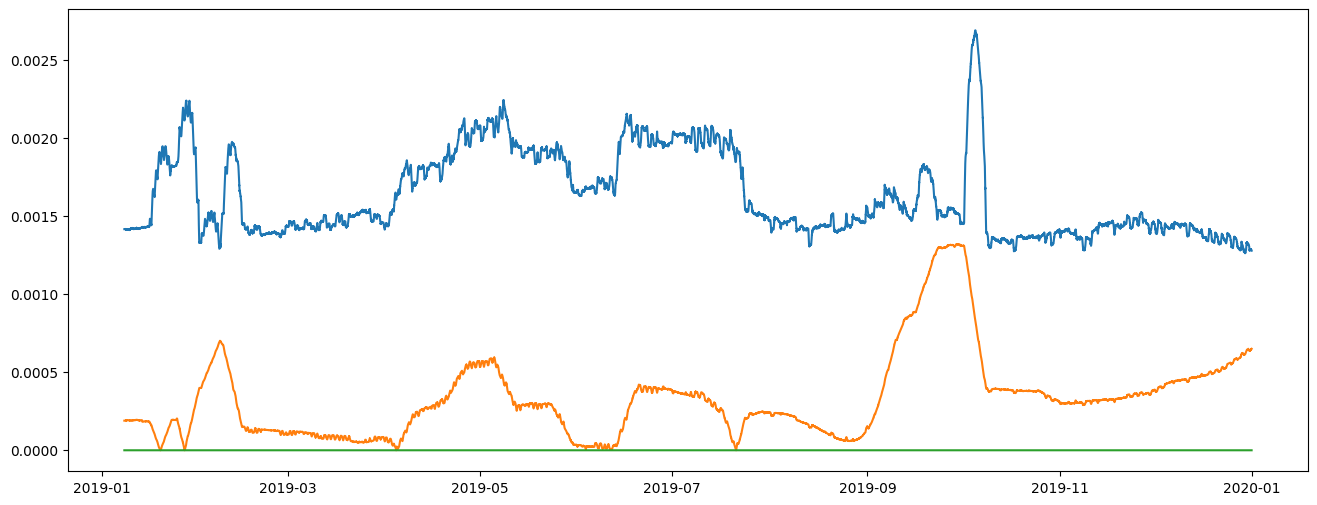

In [60]:
plotDetections('p860', faults, r_m_k, threshold)